Projet d'analyse prédictive immobilière avec Scikit-Learn
Auteur: Fidèle Ledoux

1. Import des Bibliothèques 

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score, 
                            accuracy_score, precision_score, recall_score, 
                            f1_score, roc_auc_score, confusion_matrix, 
                            RocCurveDisplay, PrecisionRecallDisplay, classification_report)

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

import joblib
from joblib import dump


In [19]:
# Configuration
pd.set_option('display.float_format', '{:.2f}'.format)  # Format décimal
plt.style.use('seaborn-v0_8')  # Style graphique
sns.set_palette("husl")  # Palette de couleurs
plt.rcParams['figure.figsize'] = (12, 6)  # Taille des figures

2. Chargement et Exploration des Données 

In [20]:
def load_data(filepath):
    """Charge les données et retourne un DataFrame"""
    data = pd.read_csv(filepath)
    print("Dimensions :", data.shape)
    print("\nStatistiques descriptives :\n", data.describe())
    
    # Analyse des valeurs manquantes
    missing_values = data.isnull().sum().sort_values(ascending=False)
    missing_values = missing_values[missing_values > 0]
    print("\nVariables avec valeurs manquantes :\n", missing_values)
    
    return data

In [21]:
# Chargement des données
data = load_data('train.csv')

Dimensions : (1460, 81)

Statistiques descriptives :
            Id  MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  \
count 1460.00     1460.00      1201.00   1460.00      1460.00      1460.00   
mean   730.50       56.90        70.05  10516.83         6.10         5.58   
std    421.61       42.30        24.28   9981.26         1.38         1.11   
min      1.00       20.00        21.00   1300.00         1.00         1.00   
25%    365.75       20.00        59.00   7553.50         5.00         5.00   
50%    730.50       50.00        69.00   9478.50         6.00         5.00   
75%   1095.25       70.00        80.00  11601.50         7.00         6.00   
max   1460.00      190.00       313.00 215245.00        10.00         9.00   

       YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  ...  WoodDeckSF  \
count    1460.00       1460.00     1452.00     1460.00  ...     1460.00   
mean     1971.27       1984.87      103.69      443.64  ...       94.24   
std        30.20  

3. Nettoyage et Prétraitement des Données 

In [22]:
def clean_data(data):
    """Nettoie et prétraite les données"""
    # Suppression des colonnes avec trop de valeurs manquantes
    cols_to_drop = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']
    data = data.drop(cols_to_drop, axis=1)
    
    # Imputation des valeurs manquantes
    # Numériques: imputation par la médiane
    num_cols = data.select_dtypes(include=['int64', 'float64']).columns
    num_imputer = SimpleImputer(strategy='median')
    data[num_cols] = num_imputer.fit_transform(data[num_cols])
    
    # Catégorielles: imputation par le mode
    cat_cols = data.select_dtypes(include=['object']).columns
    cat_imputer = SimpleImputer(strategy='most_frequent')
    data[cat_cols] = cat_imputer.fit_transform(data[cat_cols])
    
    # Encodage des variables catégorielles
    for col in cat_cols:
        data[col] = LabelEncoder().fit_transform(data[col])
    
    return data

# Nettoyage des données
cleaned_data = clean_data(data.copy())

4. Analyse Exploratoire et Visualisation

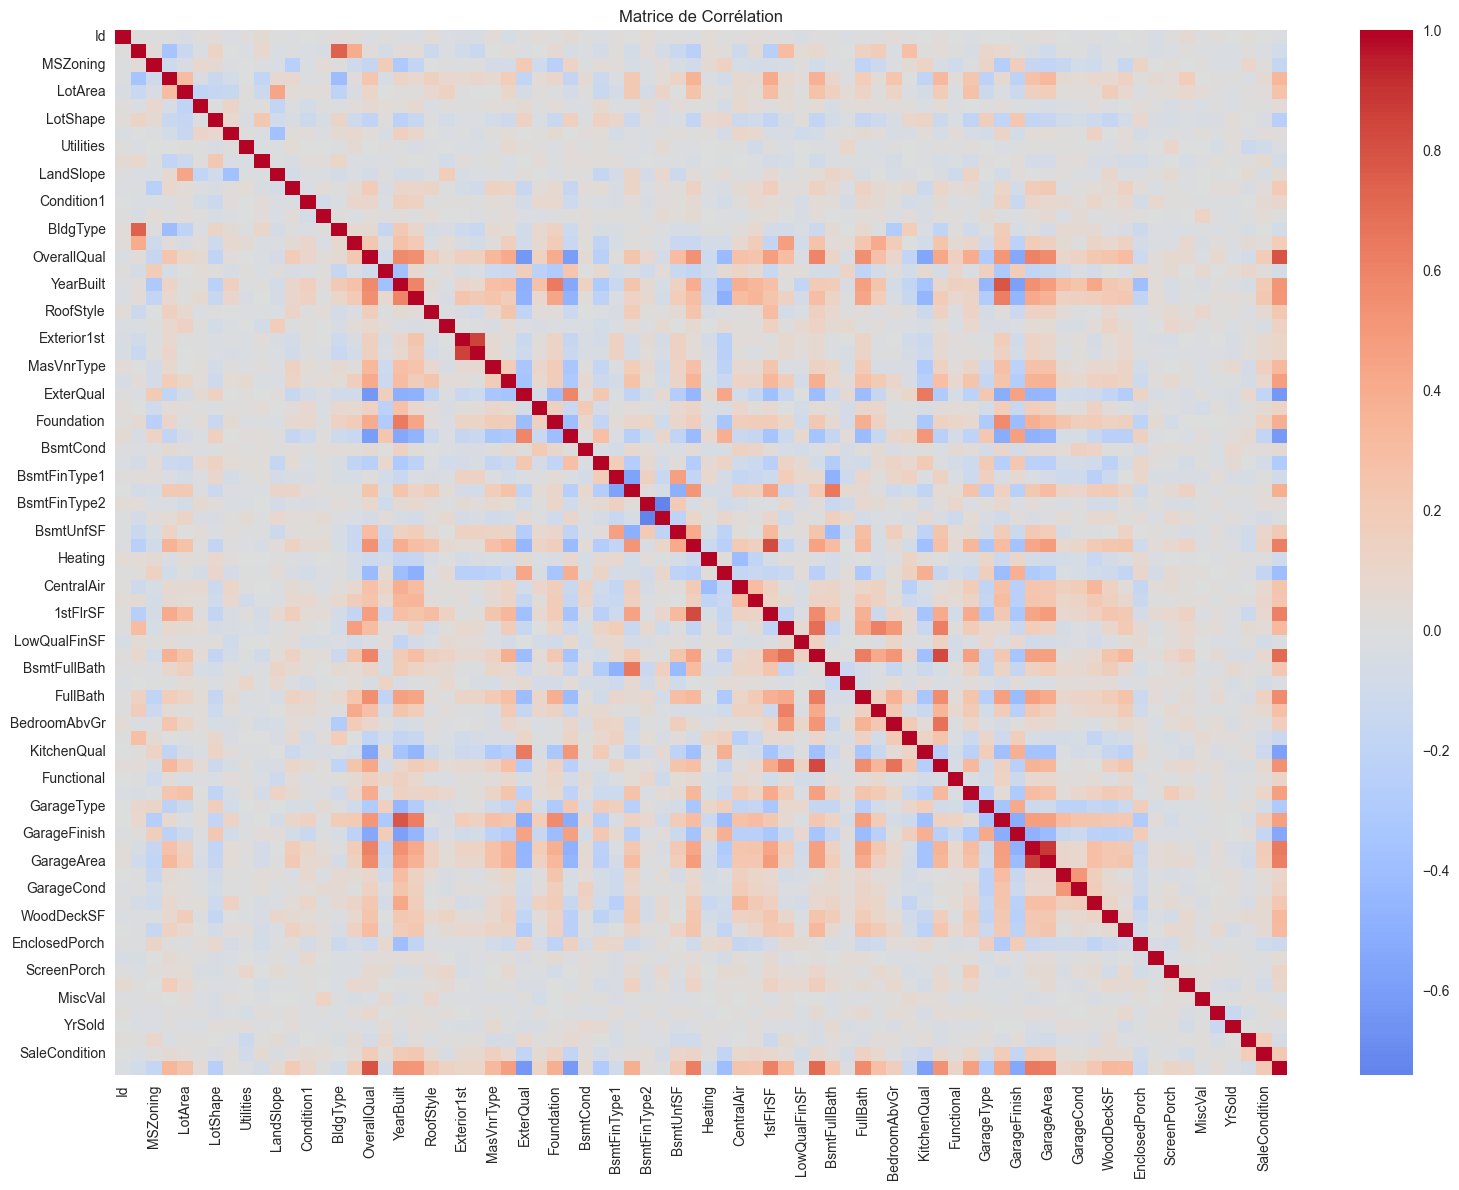

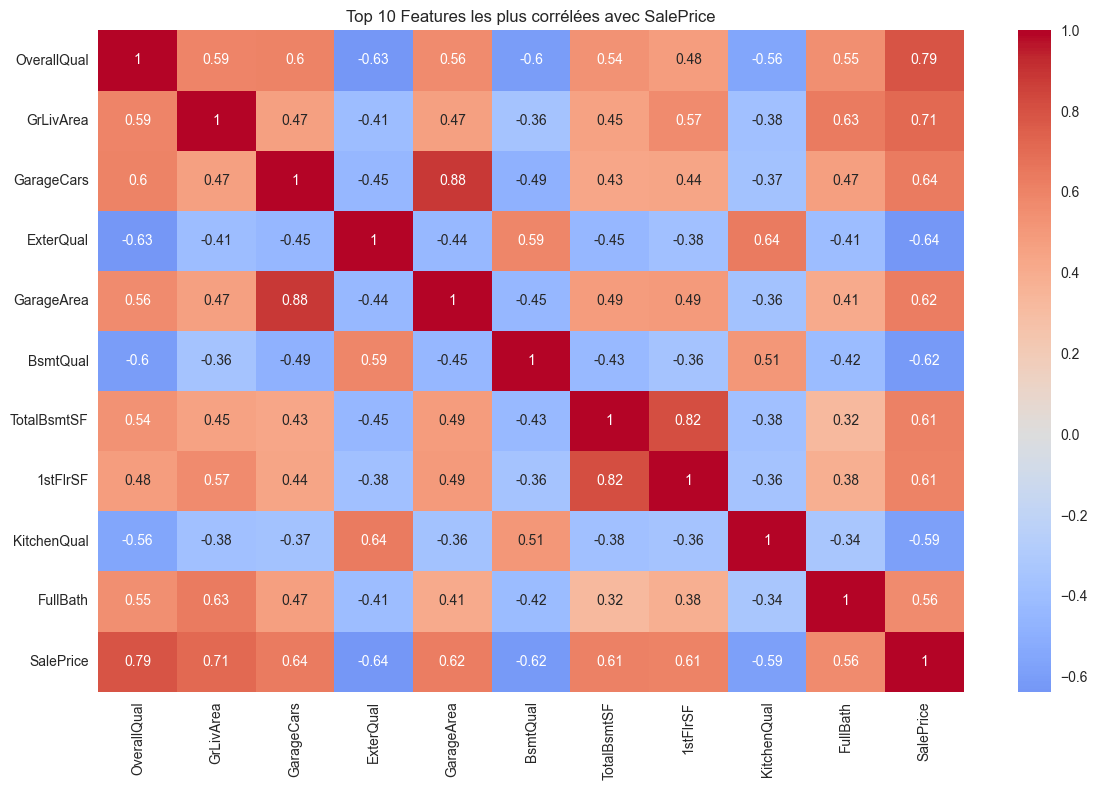

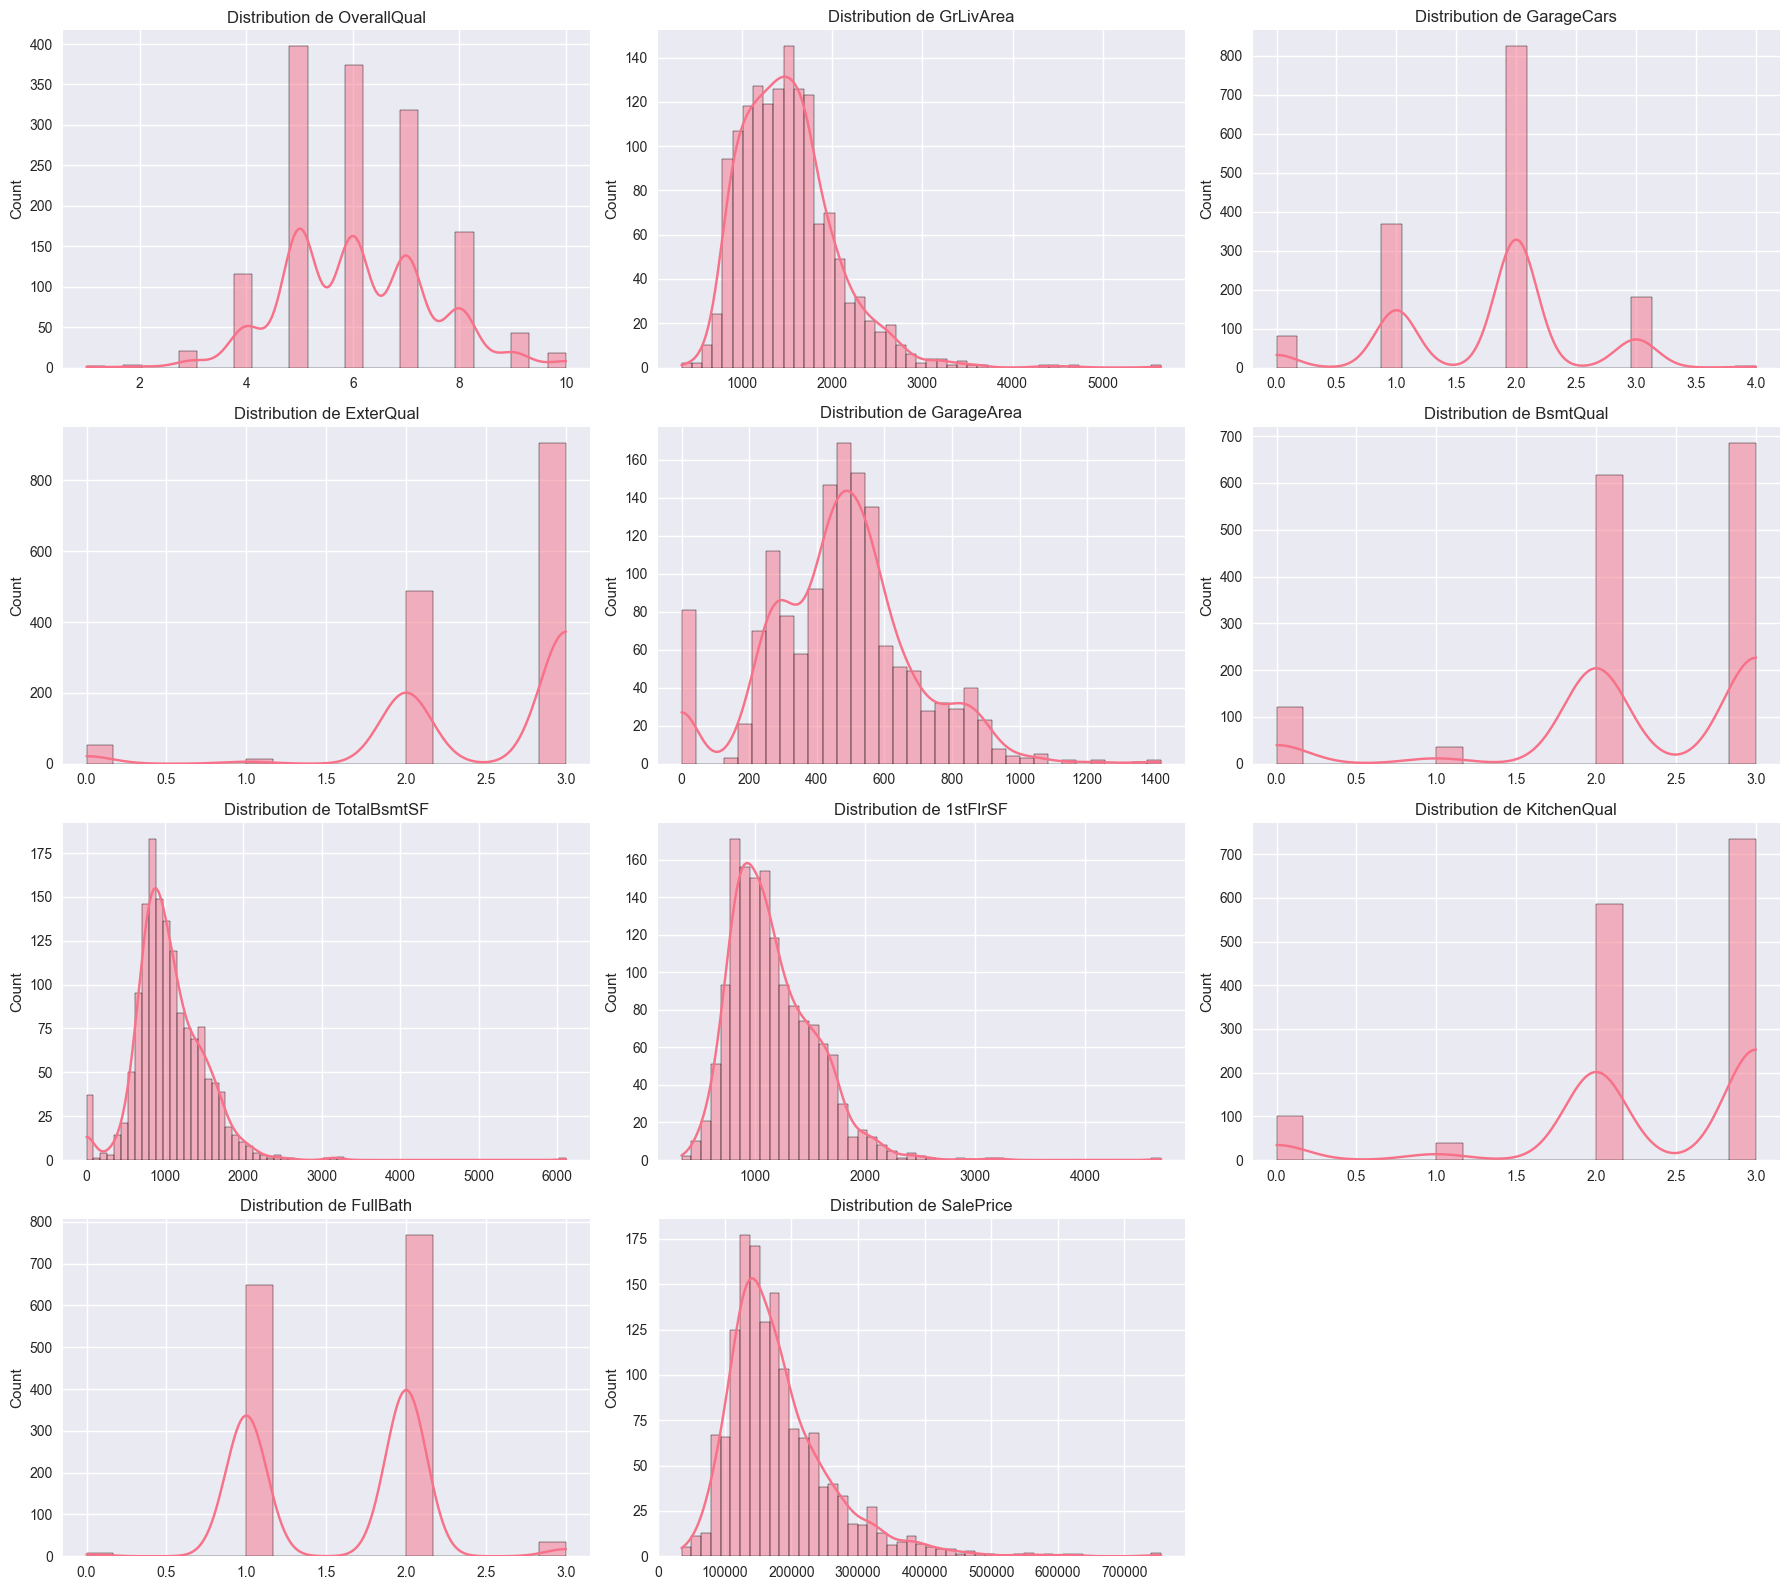

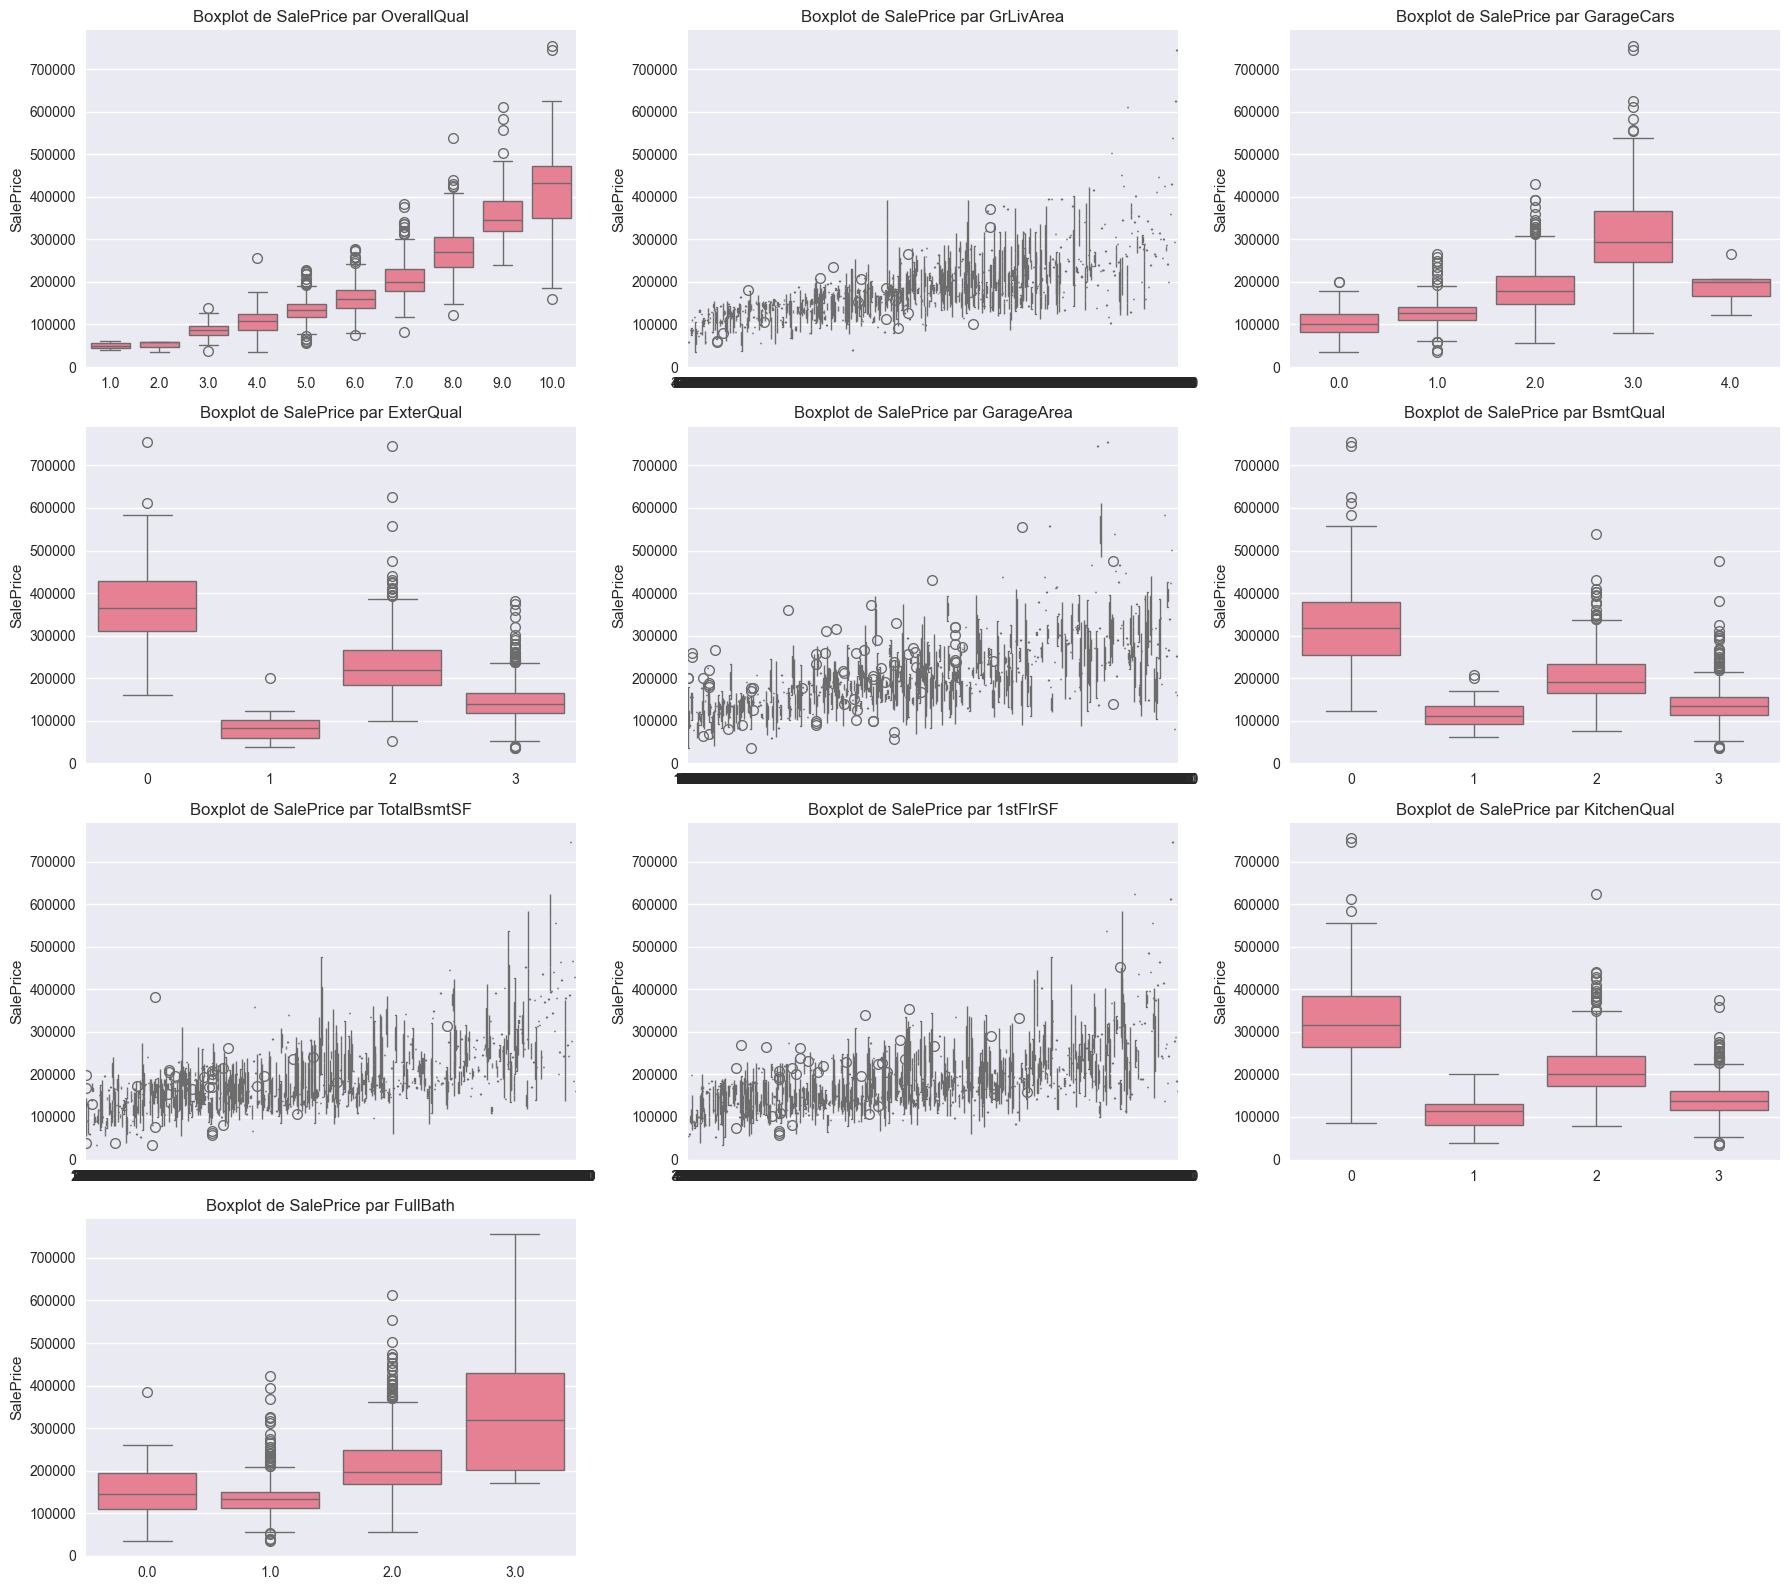

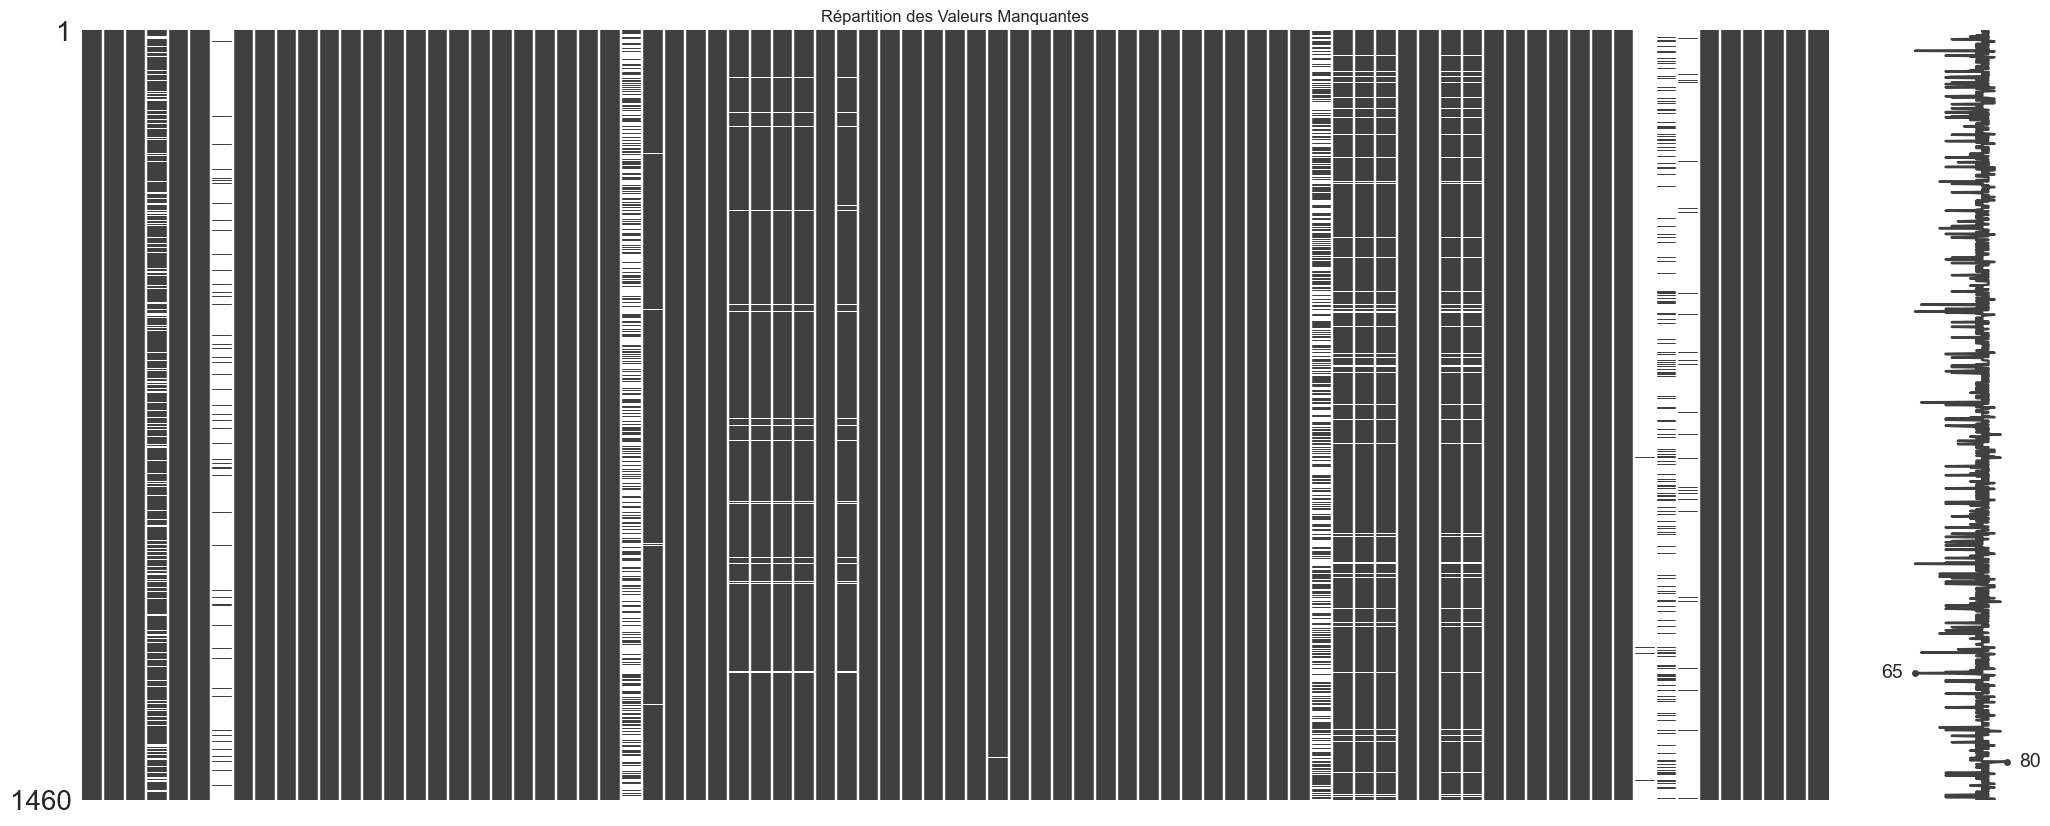

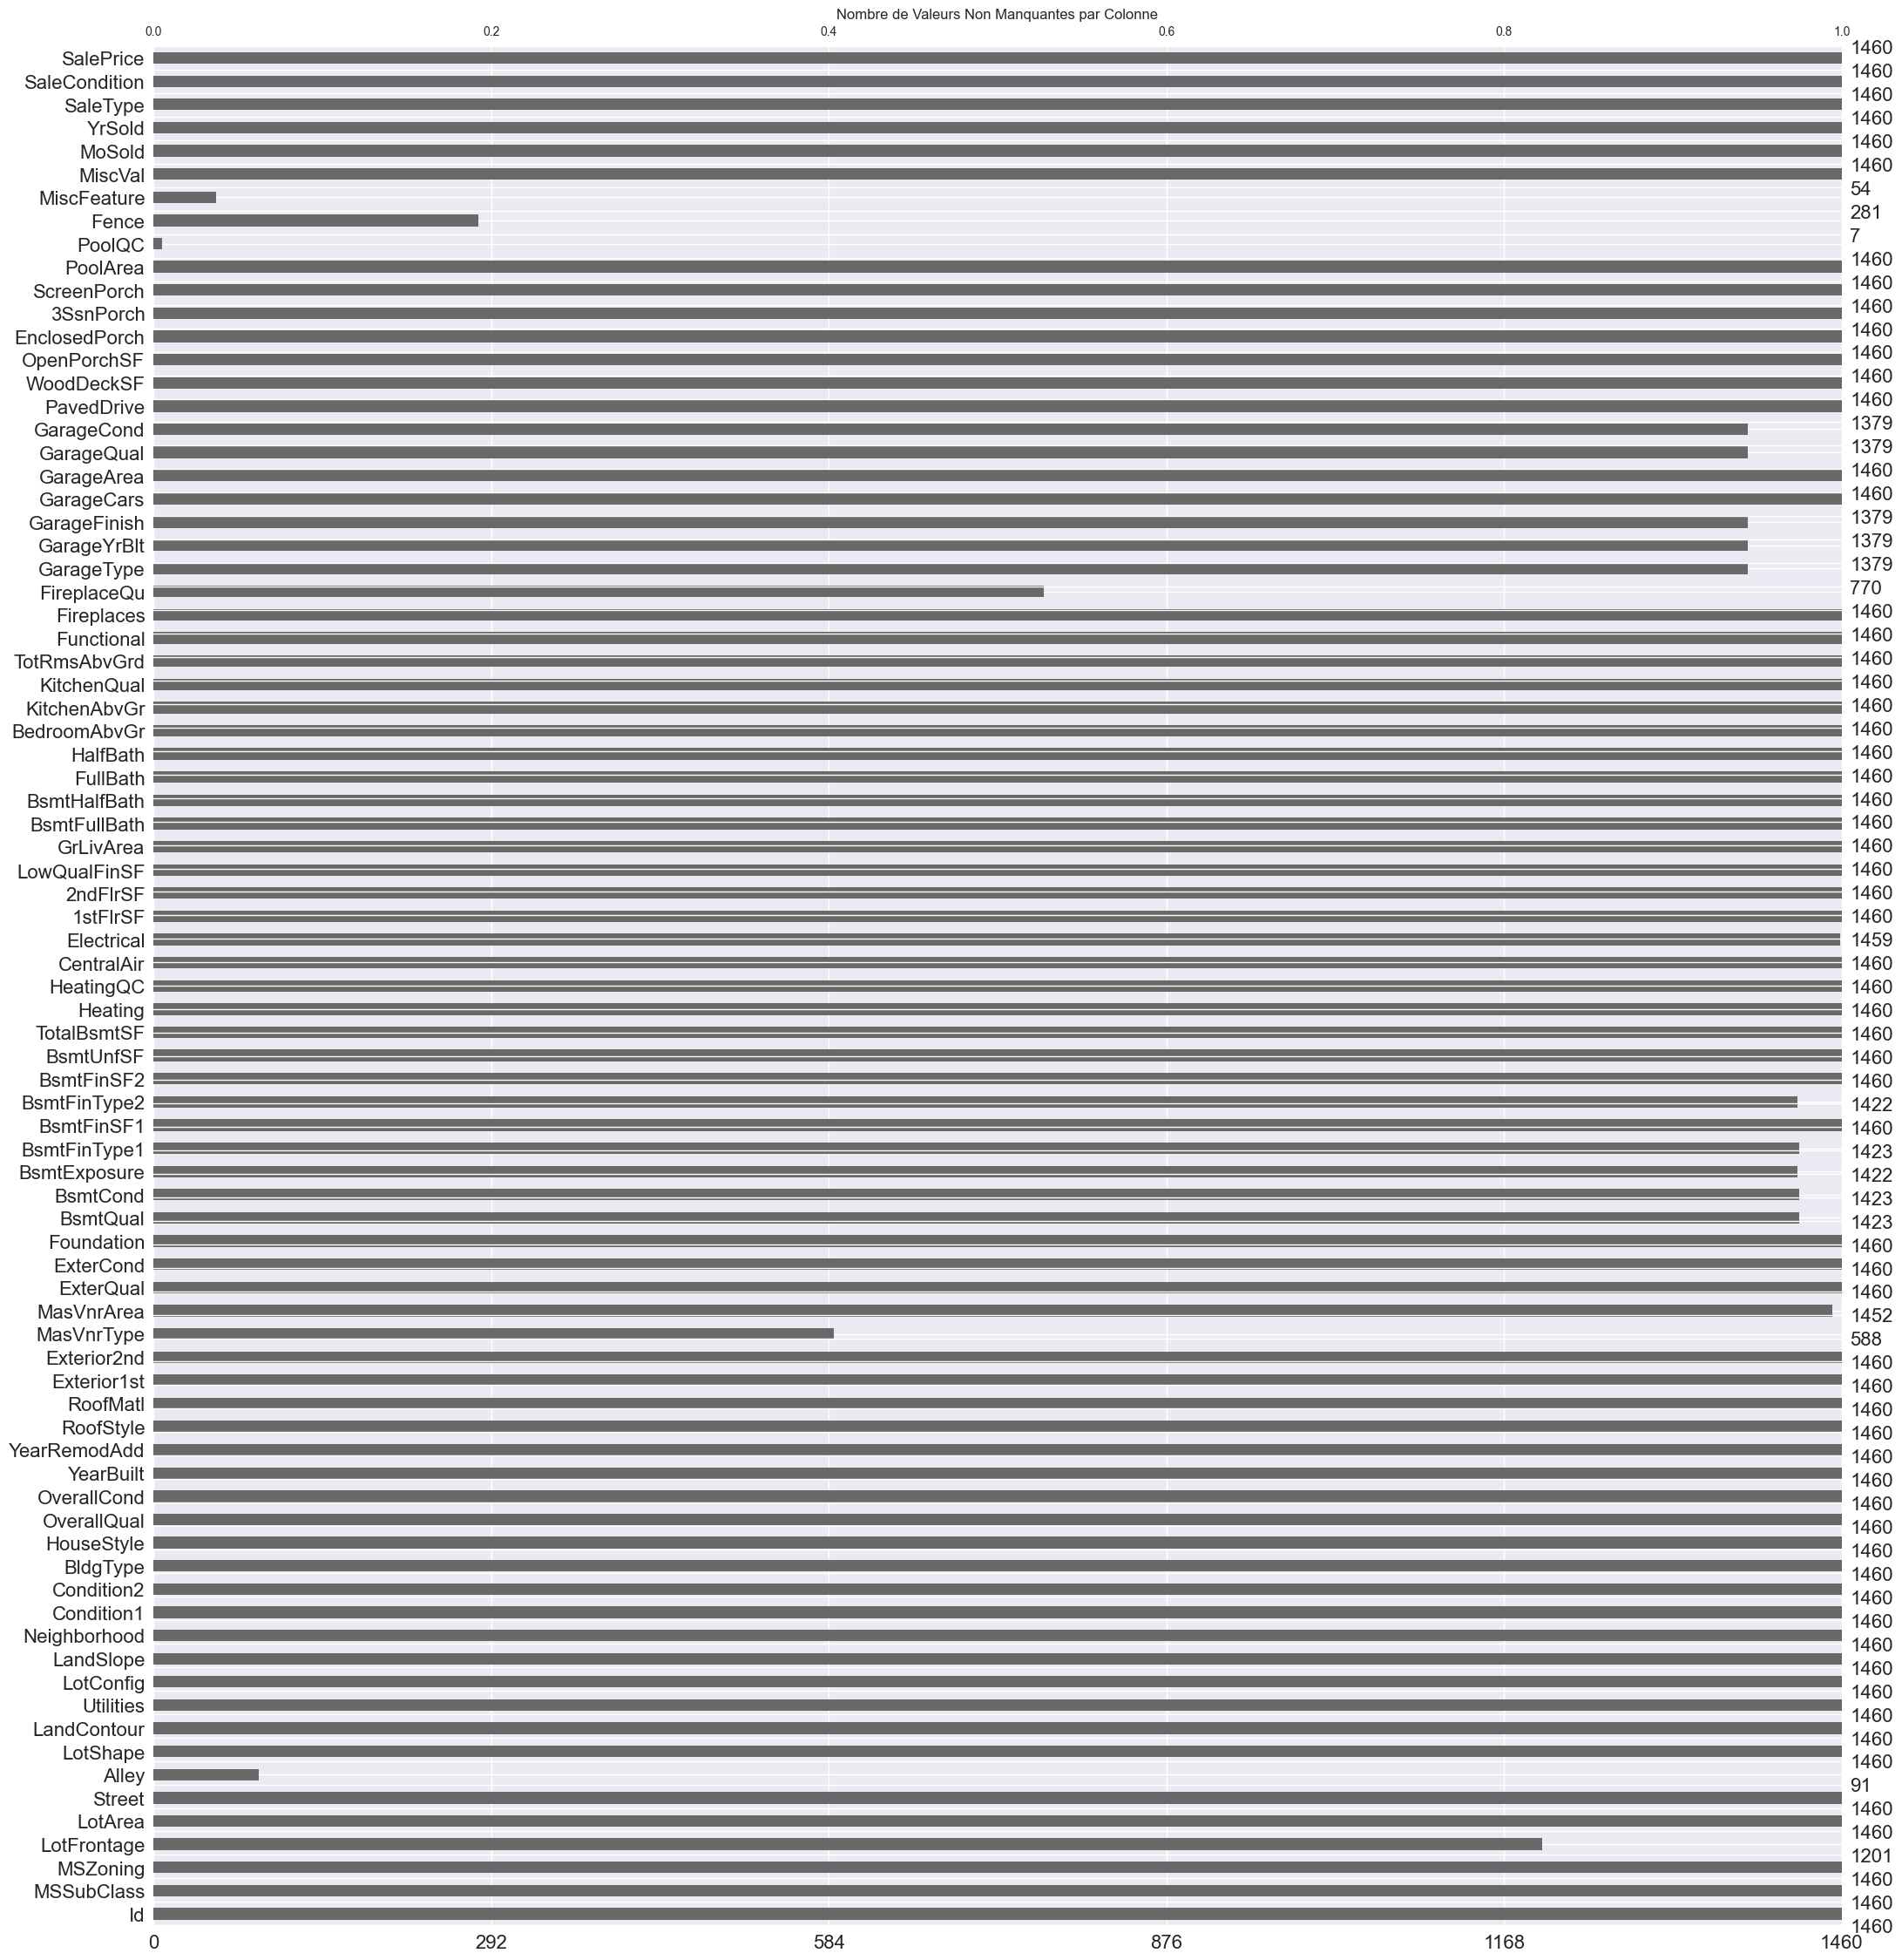

In [23]:
def plot_correlation_matrix(data, target_col, k=10):
    """Affiche la matrice de corrélation et sélectionne les k features les plus corrélées"""
    corr_matrix = data.corr()
    
    # Matrice de corrélation globale
    plt.figure(figsize=(16, 12))
    sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
    plt.title('Matrice de Corrélation')
    plt.tight_layout()
    plt.show()
    
    # Sélection des k features les plus corrélées avec la target
    corr_with_target = corr_matrix[target_col].abs().sort_values(ascending=False)
    top_features = corr_with_target[1:k+1].index.tolist()  # Exclure la target elle-même
    
    # Matrice de corrélation pour les top features
    plt.figure(figsize=(12, 8))
    sns.heatmap(data[top_features + [target_col]].corr(), annot=True, cmap='coolwarm', center=0)
    plt.title(f'Top {k} Features les plus corrélées avec {target_col}')
    plt.tight_layout()
    plt.show()
    
    return top_features

# Visualisation des corrélations et sélection des features
target = 'SalePrice'
top_features = plot_correlation_matrix(cleaned_data, target, k=10)

def plot_distributions(data, cols):
    """Affiche les distributions des variables"""
    n_cols = 3
    n_rows = (len(cols) // n_cols) + 1
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows*4))
    axes = axes.flatten()
    
    for i, col in enumerate(cols):
        if col in data.columns:
            sns.histplot(data[col], kde=True, ax=axes[i])
            axes[i].set_title(f'Distribution de {col}')
            axes[i].set_xlabel('')
    
    # Supprime les axes vides
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

# Distribution des top features et de la target
plot_distributions(cleaned_data, top_features + [target])

def plot_boxplots(data, cols, target):
    """Affiche les boxplots des variables par rapport à la target"""
    n_cols = 3
    n_rows = (len(cols) // n_cols) + 1
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows*4))
    axes = axes.flatten()
    
    for i, col in enumerate(cols):
        if col in data.columns:
            sns.boxplot(x=data[col], y=data[target], ax=axes[i])
            axes[i].set_title(f'Boxplot de {target} par {col}')
            axes[i].set_xlabel('')
    
    # Supprime les axes vides
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

# Boxplots des top features
plot_boxplots(cleaned_data, top_features, target)

def plot_missing_values(data):
    """Visualisation des valeurs manquantes"""
    msno.matrix(data)
    plt.title('Répartition des Valeurs Manquantes')
    plt.show()
    
    msno.bar(data)
    plt.title('Nombre de Valeurs Non Manquantes par Colonne')
    plt.show()

plot_missing_values(data)

5. Préparation des Données pour le Modèle 

In [24]:
def prepare_data(data, features, target):
    """Prépare les données pour l'entraînement"""
    X = data[features]
    y = data[target]
    
    # Normalisation des données
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Division en train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42
    )
    
    return X_train, X_test, y_train, y_test, scaler

# Préparation des données avec les top features
X_train, X_test, y_train, y_test, scaler = prepare_data(cleaned_data, top_features, target)


6. Définition et Évaluation des Modèles 


Linear Regression Performance:
MAE: 24071.19
MSE: 1391008965.90
RMSE: 37296.23
R2 Score: 0.82

Ridge Regression Performance:
MAE: 24067.77
MSE: 1391302563.88
RMSE: 37300.17
R2 Score: 0.82

Lasso Regression Performance:
MAE: 24071.15
MSE: 1391036718.76
RMSE: 37296.60
R2 Score: 0.82

ElasticNet Performance:
MAE: 24167.23
MSE: 1602621417.20
RMSE: 40032.75
R2 Score: 0.79

Random Forest Performance:
MAE: 19277.08
MSE: 913796749.81
RMSE: 30229.07
R2 Score: 0.88

Gradient Boosting Performance:
MAE: 19630.31
MSE: 959476298.34
RMSE: 30975.41
R2 Score: 0.87

XGBoost Performance:
MAE: 20460.05
MSE: 1061540636.22
RMSE: 32581.29
R2 Score: 0.86

SVR Performance:
MAE: 59459.86
MSE: 7848832438.18
RMSE: 88593.64
R2 Score: -0.02


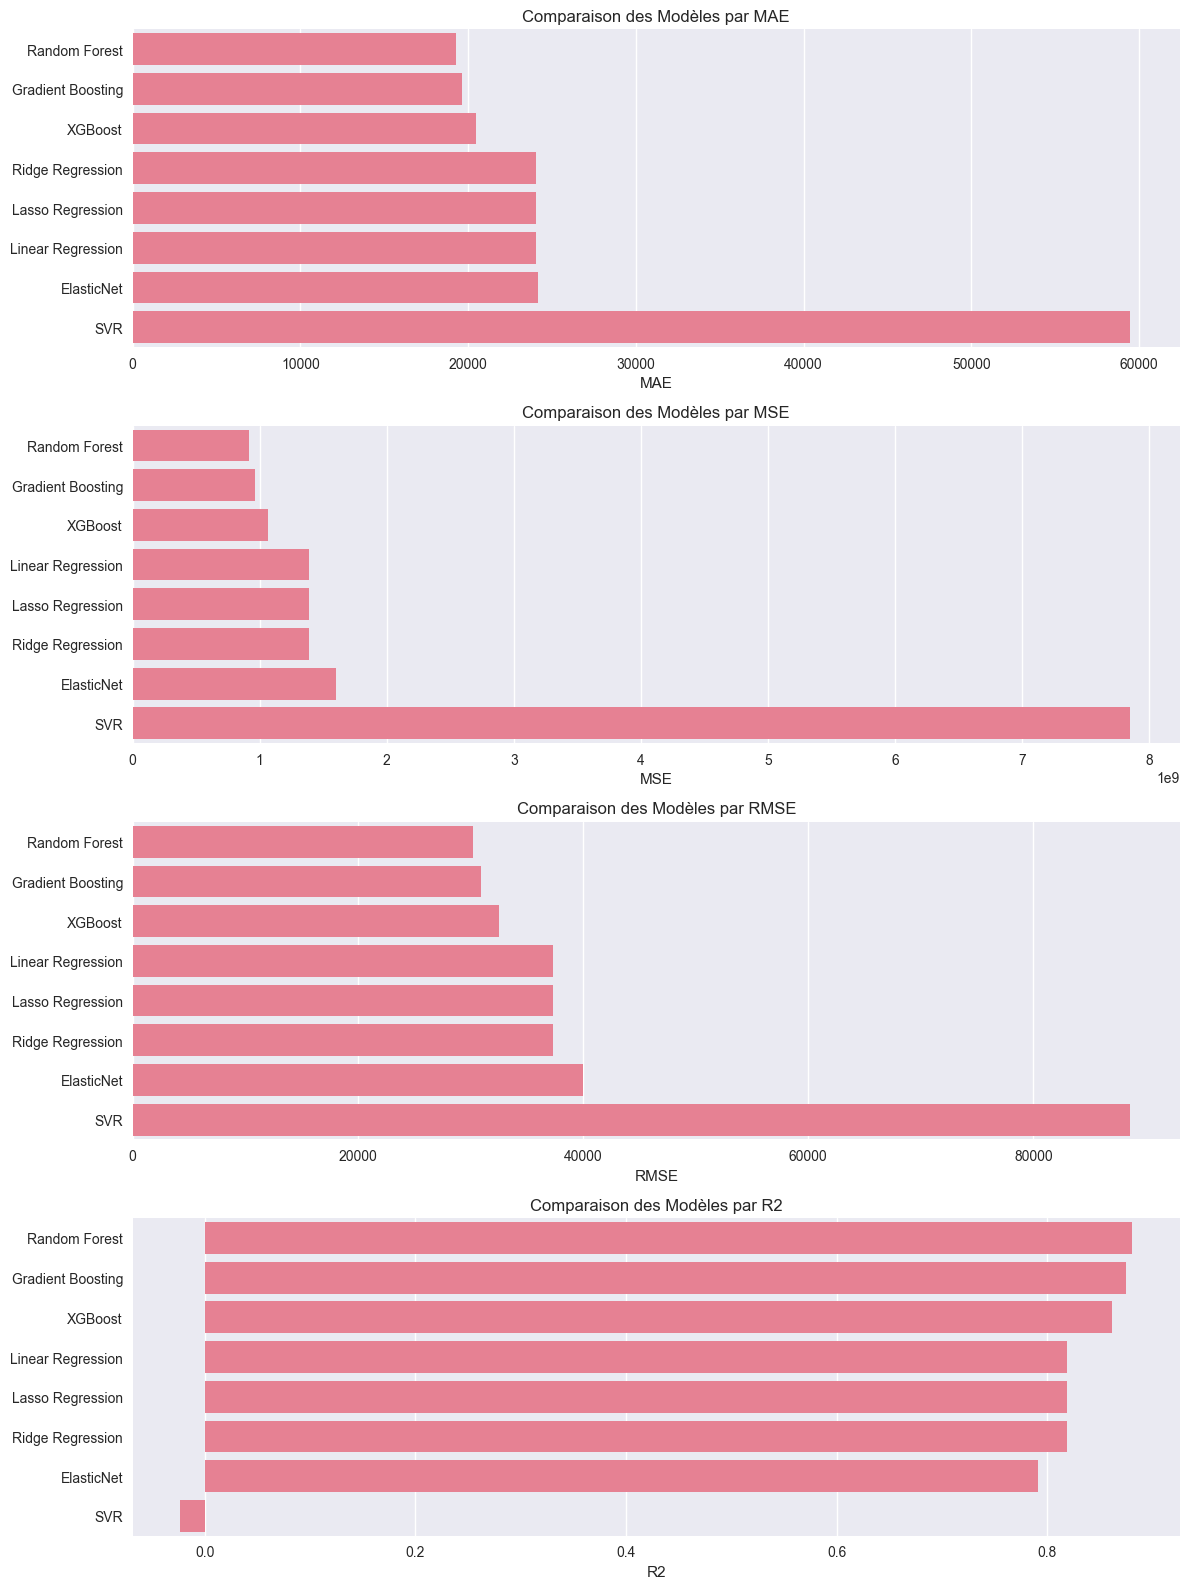

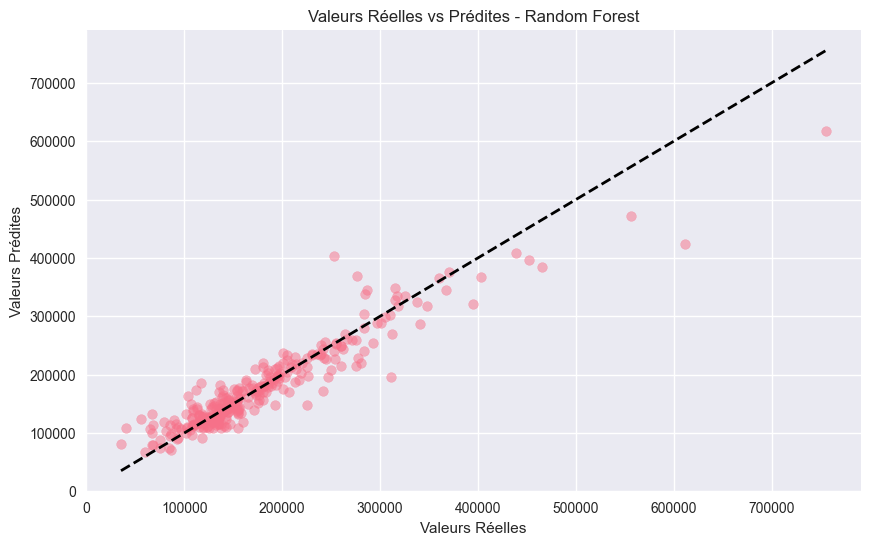

In [25]:
def evaluate_regression_models(X_train, X_test, y_train, y_test):
    """Évalue plusieurs modèles de régression et retourne les résultats"""
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(),
        'Lasso Regression': Lasso(),
        'ElasticNet': ElasticNet(),
        'Random Forest': RandomForestRegressor(random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(random_state=42),
        'XGBoost': XGBRegressor(random_state=42),
        'SVR': SVR()
    }
    
    results = {}
    
    for name, model in models.items():
        # Entraînement du modèle
        model.fit(X_train, y_train)
        
        # Prédictions
        y_pred = model.predict(X_test)
        
        # Calcul des métriques
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        
        # Stockage des résultats
        results[name] = {
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse,
            'R2': r2,
            'Model': model
        }
        
        print(f"\n{name} Performance:")
        print(f"MAE: {mae:.2f}")
        print(f"MSE: {mse:.2f}")
        print(f"RMSE: {rmse:.2f}")
        print(f"R2 Score: {r2:.2f}")
    
    return results

# Évaluation des modèles
regression_results = evaluate_regression_models(X_train, X_test, y_train, y_test)

def plot_model_performance(results):
    """Visualise les performances des modèles"""
    metrics = ['MAE', 'MSE', 'RMSE', 'R2']
    n_metrics = len(metrics)
    
    fig, axes = plt.subplots(n_metrics, 1, figsize=(12, n_metrics*4))
    
    for i, metric in enumerate(metrics):
        # Création d'un DataFrame pour la métrique actuelle
        metric_df = pd.DataFrame({
            'Model': [name for name in results],
            metric: [results[name][metric] for name in results]
        }).sort_values(by=metric, ascending=(metric != 'R2'))
        
        # Plot
        sns.barplot(x=metric, y='Model', data=metric_df, ax=axes[i])
        axes[i].set_title(f'Comparaison des Modèles par {metric}')
        axes[i].set_xlabel(metric)
        axes[i].set_ylabel('')
    
    plt.tight_layout()
    plt.show()

# Visualisation des performances
plot_model_performance(regression_results)

def plot_actual_vs_predicted(y_test, y_pred, model_name):
    """Affiche les valeurs réelles vs prédites"""
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.xlabel('Valeurs Réelles')
    plt.ylabel('Valeurs Prédites')
    plt.title(f'Valeurs Réelles vs Prédites - {model_name}')
    plt.show()

# Exemple pour le meilleur modèle (Random Forest)
best_reg_model_name = min(regression_results, key=lambda x: regression_results[x]['RMSE'])
best_reg_model = regression_results[best_reg_model_name]['Model']
y_pred = best_reg_model.predict(X_test)
plot_actual_vs_predicted(y_test, y_pred, best_reg_model_name)

7. Optimisation des Hyperparamètres 

In [26]:
def optimize_model(X_train, y_train):
    """Optimise les hyperparamètres pour Random Forest et XGBoost"""
    # Random Forest
    rf_params = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    }
    
    rf_grid = GridSearchCV(
        RandomForestRegressor(random_state=42),
        param_grid=rf_params,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    rf_grid.fit(X_train, y_train)
    
    # XGBoost
    xgb_params = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 6, 9]
    }
    
    xgb_grid = GridSearchCV(
        XGBRegressor(random_state=42),
        param_grid=xgb_params,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    xgb_grid.fit(X_train, y_train)
    
    return {
        'Random Forest': rf_grid.best_estimator_,
        'XGBoost': xgb_grid.best_estimator_
    }

# Optimisation des modèles
optimized_models = optimize_model(X_train, y_train)

# Évaluation des modèles optimisés
for name, model in optimized_models.items():
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"\n{name} Optimisé - RMSE: {rmse:.2f}, R2: {r2:.2f}")


Random Forest Optimisé - RMSE: 31529.13, R2: 0.87

XGBoost Optimisé - RMSE: 30404.84, R2: 0.88


8. Feature Importance 

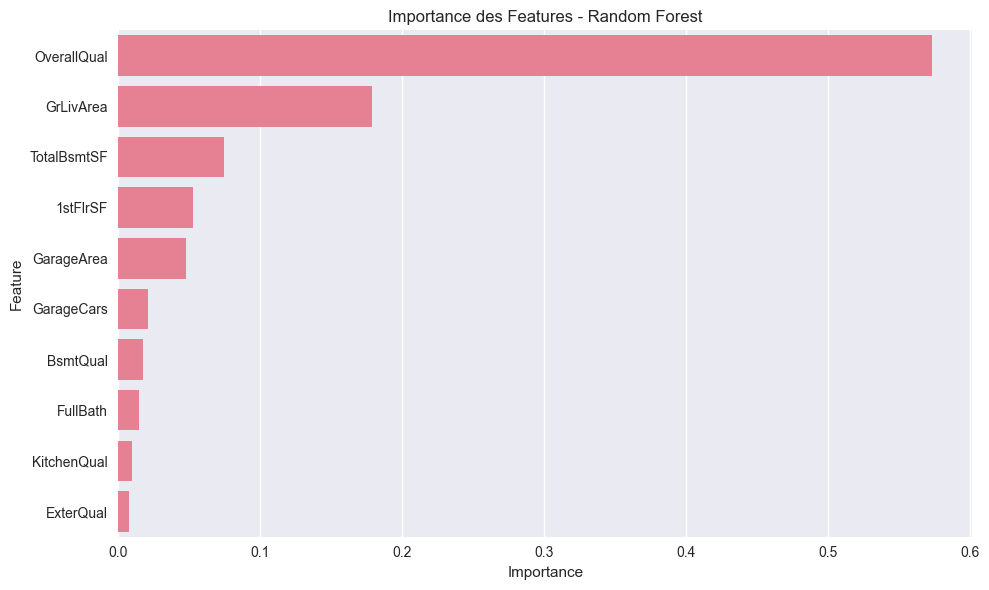

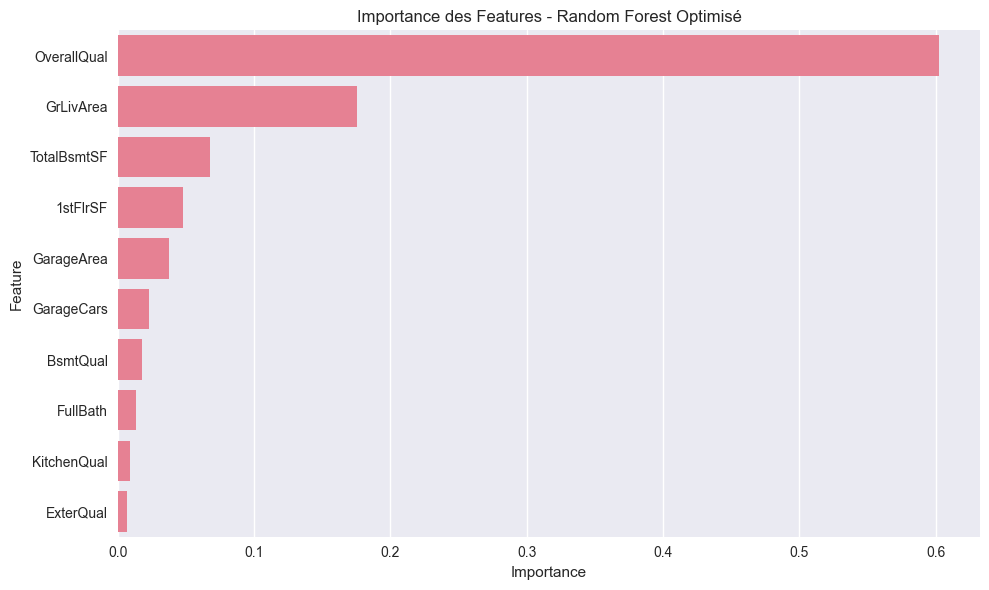

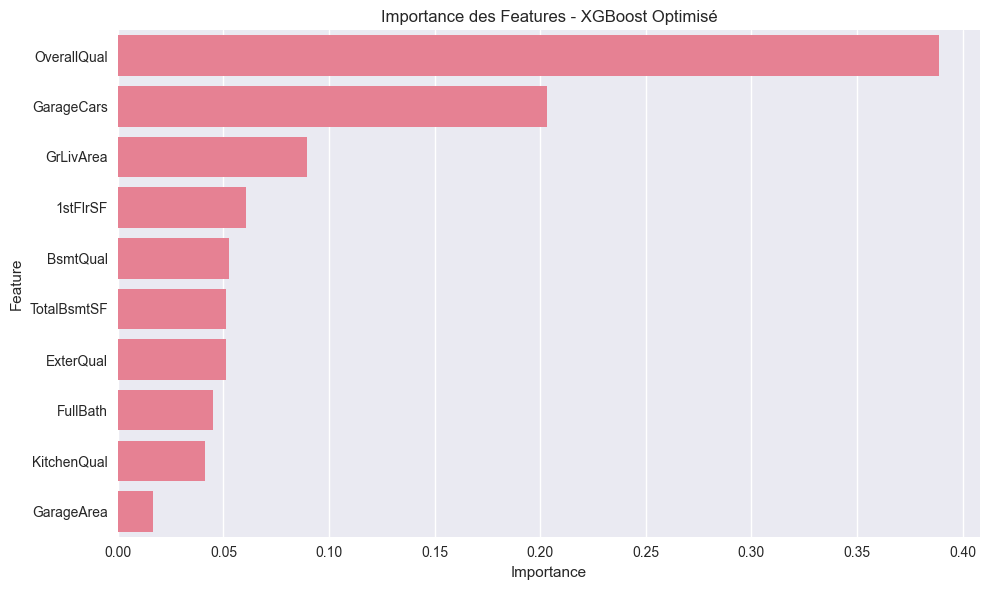

In [27]:
def plot_feature_importance(model, feature_names, model_name):
    """Affiche l'importance des features pour un modèle"""
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_)
    else:
        print(f"Impossible d'extraire l'importance des features pour {model_name}")
        return
    
    # Création d'un DataFrame pour l'importance des features
    feature_imp = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_imp)
    plt.title(f'Importance des Features - {model_name}')
    plt.tight_layout()
    plt.show()

# Importance des features pour les meilleurs modèles
plot_feature_importance(best_reg_model, top_features, best_reg_model_name)
for name, model in optimized_models.items():
    plot_feature_importance(model, top_features, name + " Optimisé")


9. Sauvegarde des Modèles et Préparations

In [28]:
def save_models_and_preparations(best_model, optimized_models, scaler, top_features):
    """Sauvegarde les modèles et les préparations pour le déploiement"""
    # Sauvegarde du scaler
    joblib.dump(scaler, 'scaler.joblib')
    
    # Sauvegarde des features sélectionnées
    joblib.dump(top_features, 'selected_features.joblib')
    
    # Sauvegarde du meilleur modèle de base
    joblib.dump(best_model, 'best_regression_model.joblib')
    
    # Sauvegarde des modèles optimisés
    for name, model in optimized_models.items():
        joblib.dump(model, f'optimized_{name.lower().replace(" ", "_")}.joblib')
    
    print("Modèles et préparations sauvegardés avec succès!")

# Sauvegarde des artefacts
save_models_and_preparations(best_reg_model, optimized_models, scaler, top_features)

Modèles et préparations sauvegardés avec succès!


10. Préparation pour Streamlit

In [29]:
def prepare_streamlit_data(data, top_features, target):
    """Prépare un sous-ensemble de données pour Streamlit"""
    streamlit_data = data[top_features + [target]].copy()
    streamlit_data.to_csv('streamlit_data.csv', index=False)
    print("Données pour Streamlit sauvegardées!")

# Préparation des données pour Streamlit
prepare_streamlit_data(cleaned_data, top_features, target)

Données pour Streamlit sauvegardées!
